# OpenEarhMap Semantinc Segmentation

original implementation found at https://github.com/bao18/open_earth_map/blob/main/Demo.ipynb

---

### Requirements

### Import
---

In [12]:
!pip uninstall open_earth_map -y


In [13]:
import os
import time
import warnings
import numpy as np
import torch
import torchvision
from pathlib import Path
import open_earth_map as oem

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### Define main parameters

In [14]:
# Path to the OpenEarthMap directory
OEM_DATA_DIR = "/home/yinqiang/OEM-20231226T014733Z-001/OEM/OpenEarthMap_Mini_with_test_labels/OpenEarthMap_Mini"

# Training and validation file list
TRAIN_LIST = os.path.join(OEM_DATA_DIR, "train.txt")
VAL_LIST = os.path.join(OEM_DATA_DIR, "val.txt")

IMG_SIZE = 512
N_CLASSES = 9
LR = 1.e-4
BATCH_SIZE = 16
NUM_EPOCHS = 500
DEVICE = "cuda"
OUTPUT_DIR = "./oem/output/JaccardLoss"
LOAD_DIR = "./oem/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Prepare training and validation file lists.

In [15]:
img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "images" in str(f)]
train_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in img_paths if f.name in np.loadtxt(VAL_LIST, dtype=str)]

print("Total samples      :", len(img_paths))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))

Total samples      : 1068
Training samples   : 663
Validation samples : 92


### Prepare training and validation augmentations.

In [16]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)

### Define training and validation dataloaders

In [17]:
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
)

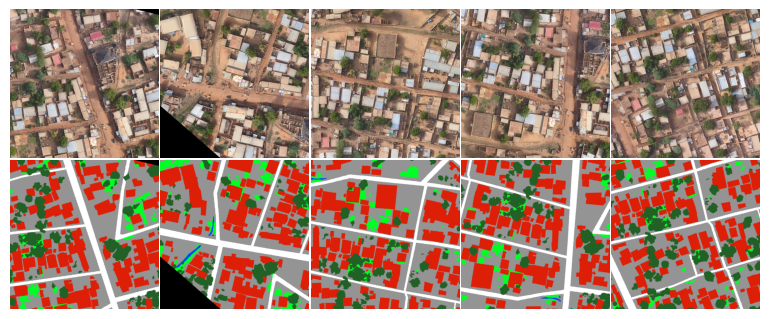

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 1
for i in range(5):
    img, msk, fn = train_data[IDX]

    img = np.moveaxis(img.numpy(), 0, -1)

    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
  
    axs[1, i].axis("off")

plt.show()

In [19]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=False,
)

In [20]:
# import torch
# import matplotlib.pyplot as plt

# # 假设类别数量
# num_classes = 9

# # 初始化计数器
# class_counts = torch.zeros(num_classes, dtype=torch.int64)

# # 遍历 dataloader
# for _, targets,*_ in train_data_loader:
#     for target in targets:
#         # 统计每个类别的像素数
#         target = torch.argmax(target, dim=0)
       
#         for i in range(num_classes):
#             class_counts[i] += torch.sum(target == i)

# # 计算总像素数
# total_pixels = class_counts.sum()

# # 计算每个类别的百分比
# class_percentages = (class_counts / total_pixels) * 100

# # 绘制柱状图
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.bar(range(num_classes), class_counts.numpy())
# plt.title("Class Counts")
# plt.xlabel("Class")
# plt.ylabel("Count")

# # 绘制百分比曲线图
# plt.subplot(1, 2, 2)
# plt.plot(range(num_classes), class_percentages.numpy(), marker='o')
# plt.title("Class Percentages")
# plt.xlabel("Class")
# plt.ylabel("Percentage (%)")

# plt.tight_layout()
# plt.show()


KeyboardInterrupt: 

### Define the network architecture, optimizer, and criterion

In [ ]:
from lovasz_losses import lovasz_softmax
network = oem.networks.UNetFormer_Modified(in_channels=3, n_classes=N_CLASSES)
# network = oem.utils.load_checkpoint(network, model_name="model.pth", model_dir=LOAD_DIR)
optimizer = torch.optim.Adam(network.parameters(), lr=LR)
criterion = oem.losses.MCCLoss()

### Train and validate the network

In [ ]:
start = time.time()
torch.backends.cudnn.enable =True
torch.backends.cudnn.benchmark = True
max_score = 0
for epoch in range(NUM_EPOCHS):

    print(f"\nEpoch: {epoch + 1}")

    train_logs = oem.runners.train_multi_loss(
        model=network,
        optimizer=optimizer,
  
        dataloader=train_data_loader,
        device=DEVICE,
    )

    valid_logs = oem.runners.valid_multi_loss(
        model=network,

        dataloader=val_data_loader,
        device=DEVICE,
    )
    epoch_score = valid_logs["Score"]
    if True:
        max_score = epoch_score
        oem.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="model.pth",
            output_dir=OUTPUT_DIR,
        )

print("Elapsed time: {:.3f} min".format((time.time() - start) / 60.0))


Epoch: 1


Train:   0%|          | 0/20 [00:11<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacty of 23.65 GiB of which 389.56 MiB is free. Including non-PyTorch memory, this process has 23.24 GiB memory in use. Of the allocated memory 22.71 GiB is allocated by PyTorch, and 73.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Testing

### Prepare testing files

In [ ]:
TEST_LIST = os.path.join(OEM_DATA_DIR, "test.txt")

img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
test_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TEST_LIST, dtype=str)]

print("Total samples   :", len(img_paths))
print("Testing samples :", len(test_fns))

Total samples   : 1068
Testing samples : 313


### Define test dataloader

In [ ]:
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES)
test_data_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=3,
    num_workers=10,
    shuffle=False,
)

### Load trained network

In [ ]:
network = oem.networks.UNetFormer_Modified(in_channels=3, num_classes=N_CLASSES)
network = oem.utils.load_checkpoint(network, model_name="model.pth", model_dir=OUTPUT_DIR)

# 0.470

Loaded model:model.pth (Epoch=29, Score=0.327)


In [ ]:
test_logs = oem.runners.valid(
model=network,
criterion=criterion,
dataloader=test_data_loader,
device=DEVICE,
)

Valid:   0%|          | 0/105 [00:00<?, ?it/s]

Valid:   3%|▎         | 3/105 [00:04<02:32,  1.50s/it, Loss=0.431, Score=0.322]


KeyboardInterrupt: 

### Visualize predictions

(1024, 1024) [0 1 2 3 5 7 8]
(1024, 1024) [0 1 2 3 5 6 7 8]
(1024, 1024) [0 1 2 3 4 5 6 7 8]
(1024, 1024) [0 1 2 3 5 6 7 8]
(1024, 1024) [0 1 2 3 5 6 7 8]
(1024, 1024) [0 1 2 3 5 6 7 8]


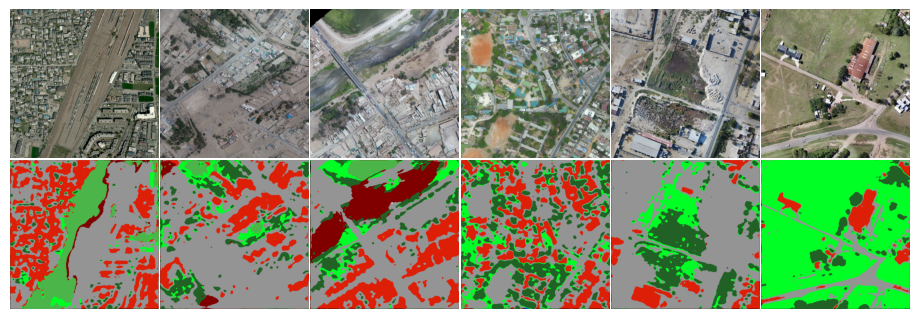

In [ ]:
# visualize predictions
NPLOT = 6
idxs = np.argsort(np.random.rand(len(test_fns)))[:NPLOT]

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, *_ = test_data[idx]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()
    
    img = np.moveaxis(img.numpy(), 0, -1)
    label = np.argmax(prd.numpy(), axis=0)
    print(label.shape, np.unique(label))
    prd = oem.utils.make_rgb(label)

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(prd)
    axs[1, i].axis("off")
plt.show()

### Save predictions in png files

In [ ]:
import math
from PIL import Image

PR_DIR = "./save_data" # <= change path where you save predictions
os.makedirs(PR_DIR, exist_ok=True)

save_fns = []

network.eval().to(DEVICE)
for test_fn in test_fns:
    img = Image.fromarray(oem.dataset.load_multiband(test_fn))

    w, h = img.size[:2]
    power_h = math.ceil(np.log2(h) / np.log2(2))
    power_w = math.ceil(np.log2(w) / np.log2(2))
    if 2**power_h != h or 2**power_w != w:
      img = img.resize((2**power_w, 2**power_h), resample=Image.BICUBIC)
    img = np.array(img)

    # test time augmentation
    imgs = []
    imgs.append(img.copy())
    imgs.append(img[:, ::-1, :].copy())
    imgs.append(img[::-1, :, :].copy())
    imgs.append(img[::-1, ::-1, :].copy())

    input = torch.cat([torchvision.transforms.functional.to_tensor(x).unsqueeze(0) for x in imgs], dim=0).float().to(DEVICE)

    pred = []
    with torch.no_grad():
      msk = network(input)
      msk = torch.softmax(msk[:, :, ...], dim=1)
      msk = msk.cpu().numpy()
      pred = (msk[0, :, :, :] + msk[1, :, :, ::-1] + msk[2, :, ::-1, :] + msk[3, :, ::-1, ::-1])/4

    pred = Image.fromarray(pred.argmax(axis=0).astype("uint8"))
    y_pr = pred.resize((w, h), resample=Image.NEAREST)

    filename = os.path.basename(test_fn).replace('tif','png')
    save_fn = os.path.join(PR_DIR, filename)
    y_pr.save(save_fn)
    save_fns.append(save_fn)